## Biomedical: Machine Translation

Dataset Source: https://huggingface.co/datasets/paolo-ruggirello/biomedical-dataset

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from transformers import DataCollatorForSeq2Seq, MBart50Tokenizer, AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, set_seed

import datasets
from datasets import Dataset, DatasetDict, load_dataset

import evaluate

!git lfs install

Git LFS initialized.


#### Versions of Software & Libraries Used

In [2]:
print("Transformers:".rjust(15), transformers.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("NumPy:".rjust(15), np.__version__)
print("Python:".rjust(15), sys.version[0:6]) 
print("Datasets:".rjust(15), datasets.__version__)

  Transformers: 4.26.1
        Pandas: 2.0.3
         NumPy: 1.25.1
        Python: 3.9.12
      Datasets: 2.13.1


#### Ingest & Start Preprocessing Data

In [3]:
data = load_dataset("paolo-ruggirello/biomedical-dataset")

data

Found cached dataset csv (/Users/briandunn/.cache/huggingface/datasets/paolo-ruggirello___csv/paolo-ruggirello--biomedical-dataset-63fadaed99250393/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'en', 'it'],
        num_rows: 262034
    })
})

#### Convert Dataset to Pandas DataFrame

In [4]:
data.set_format(type="pandas")

df = data['train'][:]

df = df.drop(columns=['Unnamed: 0'])

df = df.drop_duplicates()

df = df.reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144926 entries, 0 to 144925
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   en      144926 non-null  object
 1   it      144926 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


#### Visual: Length of English Entries

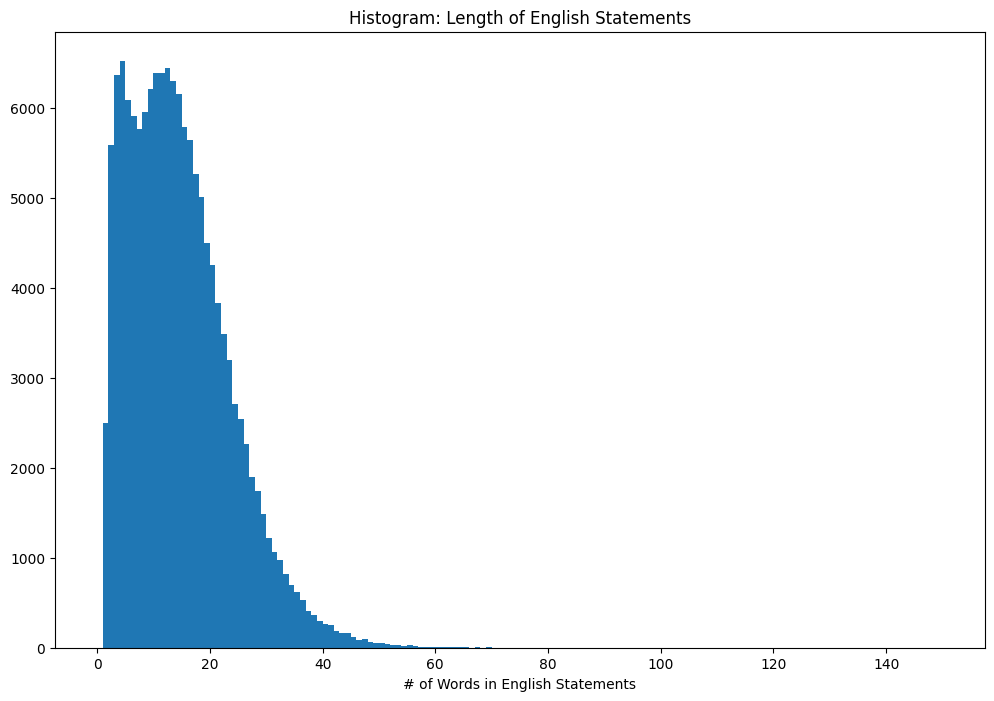

The Maximum length of English text (in words) is 112 words.


In [5]:
df['english_length'] = df['en'].str.split().str.len()

n_bin = 150
df.hist('english_length', 
        grid=False, 
        figsize=(12,8), 
        range=(0,n_bin), 
        bins=n_bin)
plt.title('Histogram: Length of English Statements')
plt.xlabel('# of Words in English Statements')
plt.show()

print(f"The Maximum length of English text (in words) is {max(df['english_length'])} words.")

#### Visual: Length of Italian Entries

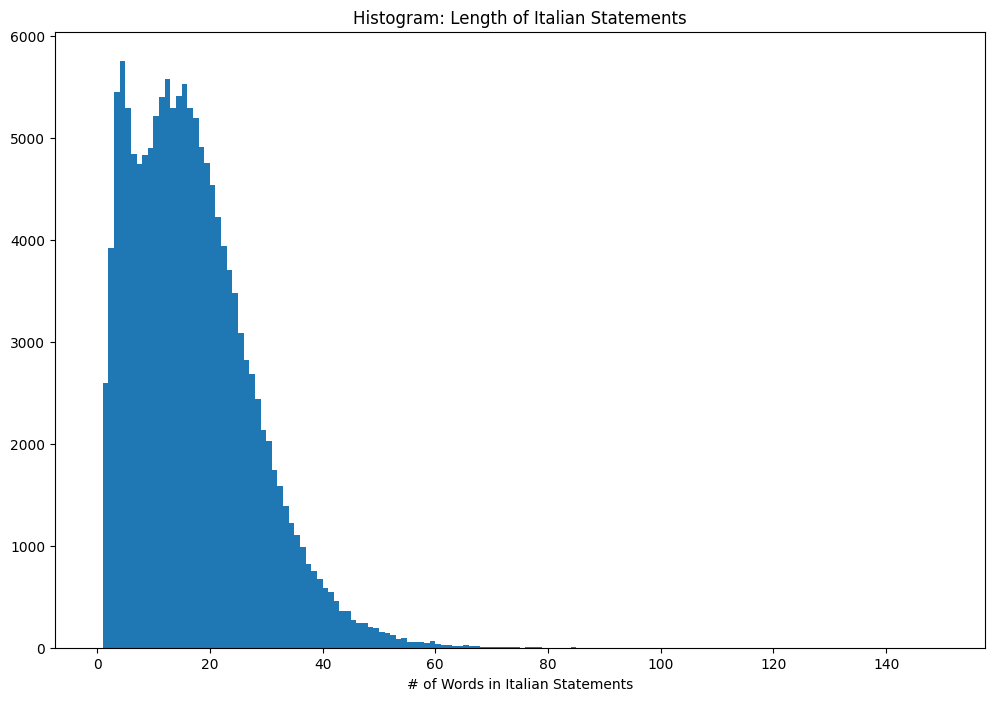

The Maximum length of Italian text (in words) is 171 words.


In [6]:
df['italian_length'] = df['it'].str.split().str.len()

n_bin=150
df.hist('italian_length', 
        grid=False, 
        range=(0,n_bin), 
        figsize=(12,8), 
        bins=n_bin)
plt.title('Histogram: Length of Italian Statements')
plt.xlabel('# of Words in Italian Statements')
plt.show()

print(f"The Maximum length of Italian text (in words) is {max(df['italian_length'])} words.")

#### Trim Dataset Size & Drop Unnecessary Features

In [7]:
most_input_words = 31

# make sure that English text is less than 31 words
df = df[df['italian_length'] < most_input_words]

# make sure that Italian text is less than 31 words
df = df[df['english_length'] < most_input_words]

# reset the index
df = df.reset_index(drop=True)

# Remove columns that are no longer necessary
df = df.drop(columns=['italian_length', 
                   'english_length'
                   ]
             )

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129727 entries, 0 to 129726
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   en      129727 non-null  object
 1   it      129727 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


#### Final Preprocessing

In [8]:
all_data = df.to_dict(orient='records')
df = pd.Series(all_data)
df = pd.DataFrame(df)
df.rename(columns={ 0 : 'translation'}, inplace=True)
df.head()

,translation
0,"{'en': 'hepatic and biliary disorders', 'it': ..."
1,{'en': 'approach to the patient with liver dis...
2,"{'en': 'portal hypertension', 'it': 'ipertensi..."
3,{'en': 'portal hypertension is elevated pressu...
4,{'en': 'it is caused most often by cirrhosis s...


#### Convert to Dataset Format & Split into Train/Test/Eval Datasets

In [9]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.65)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

print(f"\nTraining Dataset Example:\n{ds['train'][25]}")

Training Dataset Shape: (84322, 1)
Testing Dataset Shape: (22702, 1)
Evaluation Dataset Shape: (22703, 1)

Training Dataset Example:
{'translation': {'en': 'stimulation of intestinal epithelium growth', 'it': "stimolazione della crescita dell' epitelio intestinale"}}


#### Basic Values/Constants

In [10]:
set_seed = 42
NUM_OF_EPOCHS = 1

BATCH_SIZE = 32
LEARNING_RATE = 2e-5

SOURCE_LANGUAGE = "en"
TARGET_LANGUAGE = "it"

MAX_LENGTH = int((most_input_words - 1) * 2)
MODEL_CKPT = "facebook/mbart-large-50"

MODEL_NAME = f"{MODEL_CKPT.split(f'/')[-1]}-Biomedical_Dataset"
DEVICE = torch.device("cpu")

REPORTS_TO = "tensorboard"
STRATEGY = "epoch"

print(f"The training device is {str(DEVICE).upper()}")

The training device is CPU


#### Create Tokenizer

In [11]:
tokenizer = MBart50Tokenizer.from_pretrained(MODEL_CKPT)

if "mbart" in MODEL_CKPT:
    tokenizer.src_lang="en_XX"
    tokenizer.tgt_lang='it_IT'

#### Create Preprocessing Function

In [12]:
def tokenizing_function(examples):
    inputs = [ex[SOURCE_LANGUAGE] for ex in examples['translation']]
    targets = [ex[TARGET_LANGUAGE] for ex in examples['translation']]
    model_inputs = tokenizer(inputs, 
                             text_target=targets, 
                             max_length=MAX_LENGTH,
                             truncation=True)
    return model_inputs

#### Apply Preprocessing Function to Dataset

In [13]:
encoded_ds = ds.map(tokenizing_function, 
                    batched=True)

print(encoded_ds['train'].shape)
print(encoded_ds['test'].shape)
print(encoded_ds['eval'].shape)

Map:   0%|          | 0/84322 [00:00<?, ? examples/s]

Map:   0%|          | 0/22702 [00:00<?, ? examples/s]

Map:   0%|          | 0/22703 [00:00<?, ? examples/s]

(84322, 4)
(22702, 4)
(22703, 4)


#### Instantiate Model

In [14]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CKPT).to(DEVICE)

#### Instantiate Data Collator

In [15]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, 
                                       model=MODEL_CKPT)

#### Create Function to Compute Metrics

In [16]:
bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    if isinstance(preds, tuple):
        preds = preds[0]
    
    decoded_preds = tokenizer.batch_decode(preds, 
                                           skip_special_tokens=True)
    
    labels = np.where(labels != -100, 
                      labels, 
                      tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, 
                                            skip_special_tokens=True)
    
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, 
                                                     decoded_labels)
    
    bleu_results = bleu_metric.compute(predictions=decoded_preds, 
                                       references=decoded_labels)
    rouge_results = rouge_metric.compute(predictions=decoded_preds, 
                                         references=decoded_labels)
    
    meteor_results = meteor_metric.compute(predictions=decoded_preds, 
                                           references=decoded_labels)
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) 
                       for pred in preds]
    
    return {"bleu" : bleu_results["score"], 
            "rouge" : rouge_results, 
            "meteor" : meteor_results,
            "Prediction Lengths": prediction_lens}

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/briandunn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/briandunn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/briandunn/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Instantiate Training Arguments

In [17]:
args = Seq2SeqTrainingArguments(output_dir=MODEL_NAME, 
                                per_device_train_batch_size=BATCH_SIZE, 
                                per_device_eval_batch_size=BATCH_SIZE,
                                evaluation_strategy=STRATEGY,
                                save_strategy=STRATEGY, 
                                logging_strategy="steps", 
                                logging_steps=100,
                                logging_first_step=True,
                                learning_rate=LEARNING_RATE,
                                report_to=REPORTS_TO, 
                                weight_decay=0.01,
                                disable_tqdm=False,
                                num_train_epochs=NUM_OF_EPOCHS, 
                                predict_with_generate=True,
                                group_by_length=True,
                                hub_private_repo=True,
                                push_to_hub=True)

#### Instantiate Trainer

In [18]:
trainer = Seq2SeqTrainer(model=model, 
                         args=args, 
                         train_dataset=encoded_ds['train'], 
                         eval_dataset=encoded_ds['eval'], 
                         tokenizer=tokenizer, 
                         data_collator=data_collator,
                         compute_metrics=compute_metrics)

Cloning https://huggingface.co/DunnBC22/mbart-large-50-Biomedical_Dataset into local empty directory.


#### Train Model

In [19]:
train_results = trainer.train()

The following columns in the training set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 84322
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2636
  Number of trainable parameters = 610879488


  0%|          | 0/2636 [00:00<?, ?it/s]

{'loss': 8.7035, 'learning_rate': 1.9992412746585737e-05, 'epoch': 0.0}
{'loss': 4.7125, 'learning_rate': 1.92412746585736e-05, 'epoch': 0.04}
{'loss': 2.2474, 'learning_rate': 1.8482549317147193e-05, 'epoch': 0.08}
{'loss': 2.1081, 'learning_rate': 1.772382397572079e-05, 'epoch': 0.11}
{'loss': 10.4999, 'learning_rate': 1.6965098634294384e-05, 'epoch': 0.15}
{'loss': 8.0094, 'learning_rate': 1.620637329286798e-05, 'epoch': 0.19}
{'loss': 6.8502, 'learning_rate': 1.544764795144158e-05, 'epoch': 0.23}
{'loss': 4.6808, 'learning_rate': 1.4688922610015174e-05, 'epoch': 0.27}
{'loss': 1.7194, 'learning_rate': 1.3930197268588772e-05, 'epoch': 0.3}
{'loss': 1.5539, 'learning_rate': 1.3171471927162369e-05, 'epoch': 0.34}
{'loss': 1.3725, 'learning_rate': 1.2412746585735965e-05, 'epoch': 0.38}
{'loss': 1.3256, 'learning_rate': 1.1654021244309562e-05, 'epoch': 0.42}
{'loss': 1.3857, 'learning_rate': 1.0895295902883156e-05, 'epoch': 0.46}
{'loss': 2.0923, 'learning_rate': 1.0136570561456753e-05,

The following columns in the evaluation set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 22703
  Batch size = 32
Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



  0%|          | 0/710 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1

{'eval_loss': 0.9424718022346497, 'eval_bleu': 38.98930004876216, 'eval_rouge': {'rouge1': 0.6826259612196924, 'rouge2': 0.473675987811788, 'rougeL': 0.6586445010303293, 'rougeLsum': 0.6585487473231793}, 'eval_meteor': {'meteor': 0.6299677745833094}, 'eval_Prediction Lengths': [28, 15, 19, 14, 7, 9, 19, 12, 23, 32, 24, 24, 20, 23, 19, 12, 14, 22, 33, 40, 8, 33, 19, 32, 33, 21, 19, 47, 13, 15, 46, 33, 10, 16, 24, 40, 29, 4, 20, 21, 9, 7, 27, 20, 20, 21, 13, 10, 33, 25, 51, 29, 35, 7, 24, 24, 35, 29, 42, 53, 24, 4, 5, 46, 22, 18, 14, 35, 29, 36, 23, 27, 37, 48, 11, 7, 31, 13, 15, 11, 48, 30, 24, 10, 20, 28, 40, 31, 9, 9, 22, 9, 41, 26, 29, 38, 14, 30, 13, 18, 19, 33, 29, 38, 37, 42, 8, 22, 42, 11, 6, 7, 10, 24, 8, 14, 30, 29, 39, 19, 14, 10, 17, 16, 15, 28, 38, 17, 33, 16, 37, 22, 34, 31, 8, 19, 8, 12, 17, 34, 26, 31, 29, 39, 26, 22, 24, 33, 28, 33, 15, 13, 35, 29, 40, 9, 24, 39, 27, 11, 28, 13, 9, 17, 14, 13, 20, 9, 11, 26, 15, 30, 21, 22, 18, 31, 16, 45, 8, 21, 37, 20, 35, 28, 37, 35, 

Model weights saved in mbart-large-50-Biomedical_Dataset/checkpoint-2636/pytorch_model.bin
tokenizer config file saved in mbart-large-50-Biomedical_Dataset/checkpoint-2636/tokenizer_config.json
Special tokens file saved in mbart-large-50-Biomedical_Dataset/checkpoint-2636/special_tokens_map.json
tokenizer config file saved in mbart-large-50-Biomedical_Dataset/tokenizer_config.json
Special tokens file saved in mbart-large-50-Biomedical_Dataset/special_tokens_map.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 144797.2819, 'train_samples_per_second': 0.582, 'train_steps_per_second': 0.018, 'train_loss': 2.3971099925873314, 'epoch': 1.0}


#### Push Model to HuggingFace Hub (My Profile!)

In [20]:
trainer.push_to_hub()

Saving model checkpoint to mbart-large-50-Biomedical_Dataset
Configuration saved in mbart-large-50-Biomedical_Dataset/config.json
Configuration saved in mbart-large-50-Biomedical_Dataset/generation_config.json
Model weights saved in mbart-large-50-Biomedical_Dataset/pytorch_model.bin
tokenizer config file saved in mbart-large-50-Biomedical_Dataset/tokenizer_config.json
Special tokens file saved in mbart-large-50-Biomedical_Dataset/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/2.28G [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

Upload file runs/Jul15_20-25-28_Brians-Mac-mini.local/events.out.tfevents.1689470739.Brians-Mac-mini.local.133…

To https://huggingface.co/DunnBC22/mbart-large-50-Biomedical_Dataset
   25c37df..4662d16  main -> main

   25c37df..4662d16  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'metrics': [{'name': 'Bleu', 'type': 'bleu', 'value': 38.98930004876216}, {'name': 'Rouge', 'type': 'rouge', 'value': {'rouge1': 0.6826259612196924, 'rouge2': 0.473675987811788, 'rougeL': 0.6586445010303293, 'rougeLsum': 0.6585487473231793}}]}


Upload file .DS_Store: 100%|##########| 6.00k/6.00k [00:00<?, ?B/s]

To https://huggingface.co/DunnBC22/mbart-large-50-Biomedical_Dataset
   4662d16..d0f76d2  main -> main

   4662d16..d0f76d2  main -> main



'https://huggingface.co/DunnBC22/mbart-large-50-Biomedical_Dataset/commit/4662d1678ae82a4cbb69a46ccaa719b7e2e5ee0e'

#### Save & Log Model

In [21]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to mbart-large-50-Biomedical_Dataset
Configuration saved in mbart-large-50-Biomedical_Dataset/config.json
Configuration saved in mbart-large-50-Biomedical_Dataset/generation_config.json
Model weights saved in mbart-large-50-Biomedical_Dataset/pytorch_model.bin
tokenizer config file saved in mbart-large-50-Biomedical_Dataset/tokenizer_config.json
Special tokens file saved in mbart-large-50-Biomedical_Dataset/special_tokens_map.json
Saving model checkpoint to mbart-large-50-Biomedical_Dataset
Configuration saved in mbart-large-50-Biomedical_Dataset/config.json
Configuration saved in mbart-large-50-Biomedical_Dataset/generation_config.json
Model weights saved in mbart-large-50-Biomedical_Dataset/pytorch_model.bin
tokenizer config file saved in mbart-large-50-Biomedical_Dataset/tokenizer_config.json
Special tokens file saved in mbart-large-50-Biomedical_Dataset/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task

***** train metrics *****
  epoch                    =                1.0
  train_loss               =             2.3971
  train_runtime            = 1 day, 16:13:17.28
  train_samples_per_second =              0.582
  train_steps_per_second   =              0.018


### Notes & Other Takeaways From This Project
****
- 

****

#### Citations

- Model Checkpoint
    > @article{tang2020multilingual, title={Multilingual Translation with Extensible Multilingual Pretraining and Finetuning}, author={Yuqing Tang and Chau Tran and Xian Li and Peng-Jen Chen and Naman Goyal and Vishrav Chaudhary and Jiatao Gu and Angela Fan}, year={2020}, eprint={2008.00401}, archivePrefix={arXiv}, primaryClass={cs.CL}}

- Metrics
    - Bleu
        > @INPROCEEDINGS{Papineni02bleu:a, author = {Kishore Papineni and Salim Roukos and Todd Ward and Wei-jing Zhu}, title = {BLEU: a Method for Automatic Evaluation of Machine Translation}, booktitle = {}, year = {2002}, pages = {311--318}}
        
        > @inproceedings{lin-och-2004-orange, title = "{ORANGE}: a Method for Evaluating Automatic Evaluation Metrics for Machine Translation", author = "Lin, Chin-Yew and Och, Franz Josef", booktitle = "{COLING} 2004: Proceedings of the 20th International Conference on Computational Linguistics", month = "aug 23{--}aug 27", year = "2004", address = "Geneva, Switzerland", publisher = "COLING", url = "https://www.aclweb.org/anthology/C04-1072", pages = "501--507",}
    
    - Rouge
        > @inproceedings{lin-2004-rouge, title = '{ROUGE}: A Package for Automatic Evaluation of Summaries', author = 'Lin, Chin-Yew', booktitle = 'Text Summarization Branches Out', month = jul, year = '2004', address = 'Barcelona, Spain', publisher = 'Association for Computational Linguistics', url = 'https://www.aclweb.org/anthology/W04-1013', pages = '74--81',}
    
    - Meteor
        > @inproceedings{banarjee2005, title = {{METEOR}: An Automatic Metric for {MT} Evaluation with Improved Correlation with Human Judgments}, author = {Banerjee, Satanjeev  and Lavie, Alon}, booktitle = {Proceedings of the {ACL} Workshop on Intrinsic and Extrinsic Evaluation Measures for Machine Translation and/or Summarization}, month = jun, year = {2005}, address = {Ann Arbor, Michigan}, publisher = {Association for Computational Linguistics}, url = {https://www.aclweb.org/anthology/W05-0909}, pages = {65--72},}